In [3]:
import numpy as np
import pandas as pd
import pickle
import copy

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Descriptors, rdFingerprintGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF

import torch
import torch.nn as nn
import sklearn
from sklearn.metrics import roc_auc_score, average_precision_score
from torch.utils.data import Dataset, DataLoader

real_200_descr = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,25,26,27,28,29,30, 31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,0,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207]

# Pre-processing

In [4]:
# MUV
# 93 k mols, 17 tasks, 436,060 measurements

muv = pd.read_csv("muv.csv")

print('Shape: ', muv.shape)

vals = muv.values.flatten()
print('# meas.: ', len([v for v in vals if str(v) != 'nan']))

muv

Shape:  (93087, 19)
# meas.:  436060


,MUV-466,MUV-548,MUV-600,MUV-644,MUV-652,MUV-689,MUV-692,MUV-712,MUV-713,MUV-733,MUV-737,MUV-810,MUV-832,MUV-846,MUV-852,MUV-858,MUV-859,mol_id,smiles
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,CID2957283,O=C(NCc1ccccc1Cl)C1CCCO1
93083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID414138,COc1cc(NCCCCCN2C(=O)c3ccccc3C2=O)c2ncccc2c1
93084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,CID718652,CCN(CC)c1ccc(/C=C2/C(=O)ON=C2C)cc1
93085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,CID2446949,Cc1cc(=O)oc2cc(OCC(=O)c3ccc4c(c3)NC(=O)CO4)ccc12


In [5]:
molecules = list(muv["smiles"])

# create mol objects
mols = list()

for smiles in molecules:
    mol = Chem.MolFromSmiles(smiles)
    mols.append(mol)

In [6]:
# ECFP fingerprints
ecfps = list()

for mol in mols:
    fp_sparseVec = rdFingerprintGenerator.GetCountFPs(
                    [mol], fpType=rdFingerprintGenerator.MorganFP
                   )[0]
    fp = np.zeros((0,), np.int8)  # Generate target pointer to fill
    DataStructs.ConvertToNumpyArray(fp_sparseVec, fp)
    
    ecfps.append(fp)

ecfps = np.array(ecfps)

ecfps.shape

(93087, 2048)

In [ ]:
# Descriptors
rdkit_descriptors = list()

for mol in mols:
    descrs = list()
    for descr in Descriptors._descList:
        _, descr_calc_fn = descr
        descrs.append(descr_calc_fn(mol))
        
    descrs = np.array(descrs)
    descrs = descrs[real_200_descr]
    rdkit_descriptors.append(descrs)
    
rdkit_descriptors = np.array(rdkit_descriptors)

rdkit_descriptors.shape

In [7]:
"""with open('rdkit_descriptors.pkl', "rb") as file:
    rdkit_descriptors = pickle.load(file)
    
rdkit_descriptors"""

array([[13.52335228, 13.52335228,  0.02397988, ...,  0.        ,
         0.        ,  0.        ],
       [11.99466951, 11.99466951,  0.06969654, ...,  0.        ,
         0.        ,  0.        ],
       [13.31086711, 13.31086711,  0.39540322, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [11.44354725, 11.44354725,  0.38396348, ...,  0.        ,
         0.        ,  0.        ],
       [12.40518167, 12.40518167,  0.04070476, ...,  0.        ,
         0.        ,  0.        ],
       [11.94644652, 11.94644652,  0.1213511 , ...,  0.        ,
         0.        ,  0.        ]])

In [8]:
features = np.hstack((ecfps, rdkit_descriptors))

print(f"Shape of features: {features.shape} \n")
print(f"Features: \n {features}")

Shape of features: (93087, 2248) 

Features: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Restructuring

In [9]:
mol_id = muv["mol_id"].to_numpy()
target_id = muv.columns.to_numpy()[:-2]
labels = muv.values[:, :-2]

print(f"Shape of labels: {labels.shape}")
print(f"Shape of mol_id: {mol_id.shape}")
print(f"Shape of target_id: {target_id.shape}")

Shape of labels: (93087, 17)
Shape of mol_id: (93087,)
Shape of target_id: (17,)


In [10]:
muv_matrix = np.empty(labels.shape, dtype=object)

for r in range(len(muv_matrix)):
    for c in range(len(muv_matrix[0])):
        label = labels[r, c]
        if label != 0.0 and label != 1.0:
            label = -1
        muv_matrix[r, c] = (r, c, int(label))

In [11]:
print(f"Shape of muv_matrix: {muv_matrix.shape} \n")
print(f"muv_matrix: \n {muv_matrix}")

Shape of muv_matrix: (93087, 17) 

muv_matrix: 
 [[(0, 0, -1) (0, 1, -1) (0, 2, -1) ... (0, 14, -1) (0, 15, -1)
  (0, 16, -1)]
 [(1, 0, 0) (1, 1, 0) (1, 2, -1) ... (1, 14, -1) (1, 15, 0) (1, 16, 0)]
 [(2, 0, -1) (2, 1, -1) (2, 2, 0) ... (2, 14, -1) (2, 15, -1) (2, 16, 0)]
 ...
 [(93084, 0, -1) (93084, 1, -1) (93084, 2, -1) ... (93084, 14, -1)
  (93084, 15, -1) (93084, 16, -1)]
 [(93085, 0, -1) (93085, 1, -1) (93085, 2, -1) ... (93085, 14, 0)
  (93085, 15, -1) (93085, 16, -1)]
 [(93086, 0, -1) (93086, 1, -1) (93086, 2, -1) ... (93086, 14, 0)
  (93086, 15, -1) (93086, 16, -1)]]


In [12]:
train_set = muv_matrix[:, :10]
validation_set = muv_matrix[:, 10:13]
test_set = muv_matrix[:, 13:16]

In [13]:
print(f"Shape of training set: {train_set.shape}")
print(f"Shape of validation set: {validation_set.shape}")
print(f"Shape of test set: {test_set.shape}")
print(f"Shape of features: {features.shape}")

Shape of training set: (93087, 10)
Shape of validation set: (93087, 3)
Shape of test set: (93087, 3)
Shape of features: (93087, 2248)


In [14]:
def filter(matrix):
    matrix_copy = matrix.copy()
    flattened = matrix_copy.reshape(-1)
    filtered = []
    for triplet in flattened:
        if triplet[2] != -1:
            filtered.append(triplet)

    return np.array(filtered)

In [15]:
filtered_train = filter(train_set)

print(f"Shape of the filtered train set: {filtered_train.shape}\n")
print(f"Filtered train set: \n {filtered_train}")

Shape of the filtered train set: (147002, 3)

Filtered train set: 
 [[    0     7     0]
 [    1     0     0]
 [    1     1     0]
 ...
 [93073     8     0]
 [93079     5     0]
 [93083     7     0]]


In [16]:
filtered_validation = filter(validation_set)

print(f"Shape of the filtered validation set: {filtered_validation.shape}\n")
print(f"Filtered validation set: \n {filtered_validation}")

Shape of the filtered validation set: (44002, 3)

Filtered validation set: 
 [[    0    11     0]
 [    1    10     0]
 [    1    12     0]
 ...
 [93073    12     0]
 [93075    11     0]
 [93081    12     0]]


In [17]:
filtered_test = filter(test_set)

print(f"Shape of the filtered test set: {filtered_test.shape}\n")
print(f"Filtered test set: \n {filtered_test}")

Shape of the filtered test set: (44136, 3)

Filtered test set: 
 [[    1    15     0]
 [    3    15     0]
 [    5    15     0]
 ...
 [93084    13     0]
 [93085    14     0]
 [93086    14     0]]


In [18]:
print(f"Train count: {np.unique(filtered_train[:, 2], return_counts=True)}")
print(f"Validation count: {np.unique(filtered_validation[:, 2], return_counts=True)}")
print(f"Test count: {np.unique(filtered_test[:, 2], return_counts=True)}")

Train count: (array([0, 1]), array([146713,    289]))
Validation count: (array([0, 1]), array([43914,    88]))
Test count: (array([0, 1]), array([44048,    88]))


# Random Forest

In [19]:
import torch
import torch.nn as nn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, roc_auc_score, average_precision_score
from collections import Counter
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [20]:
def compute_dauprc_score(predictions, labels, target_ids):
    dauprcs = list()
    target_id_list = list()
    for target_idx in torch.unique(target_ids):
        rows = torch.where(target_ids == target_idx)
        preds = predictions[rows].detach()
        y = labels[rows].int()
        if torch.unique(y).shape[0] == 2:
            number_actives = y[y == 1].shape[0]
            number_inactives = y[y == 0].shape[0]
            number_total = number_actives + number_inactives

            random_clf_auprc = number_actives / number_total
            auprc = average_precision_score(
                y.numpy().flatten(), preds.numpy().flatten()
            )
            dauprc = auprc - random_clf_auprc
            dauprcs.append(dauprc)
            target_id_list.append(target_idx.item())
        else:
            dauprcs.append(np.nan)
            target_id_list.append(target_idx.item())
    return np.nanmean(dauprcs), dauprcs, target_id_list

In [21]:
tasks = [13, 14, 15]
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
auc_results = {seed: [] for seed in seeds}
dauprc_results = {seed: [] for seed in seeds}

for seed in seeds:
    np.random.seed(seed)
    for task in tasks:
        data = filtered_test[filtered_test[:, 1] == task]
        X = features[data[:, 0]]
        y = data[:, 2]
        pos_indices = np.where(y == 1)[0]
        neg_indices = np.where(y == 0)[0]
        pos_train_indices = np.random.choice(pos_indices, size=5, replace=False)
        neg_train_indices = np.random.choice(neg_indices, size=5, replace=False)
        train_indices = np.concatenate([pos_train_indices, neg_train_indices])
        test_indices = [i for i in range(len(y)) if i not in train_indices]
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        clf = RandomForestClassifier(random_state=seed)
        clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        predictions_tensor = torch.tensor(y_pred_proba)
        labels_tensor = torch.tensor(y_test)
        target_ids_tensor = torch.zeros_like(labels_tensor)

        auc_score = roc_auc_score(y_test, y_pred_proba)
        mean_dauprc, dauprcs, target_id_list = compute_dauprc_score(
            predictions_tensor, 
            labels_tensor, 
            target_ids_tensor)

        auc_results[seed].append(auc_score)
        dauprc_results[seed].append(mean_dauprc)

mean_auc_seeds, std_auc_seeds = [], []
mean_dauprc_seeds, std_dauprc_seeds = [], []
for seed in seeds:
    auc_scores = auc_results[seed]
    mean_auc = np.mean(auc_scores)
    mean_auc_seeds.append(mean_auc)
    print(f"Seed {seed}:")
    print(f"Mean roc_auc_score = {mean_auc:.4f}")

    dauprcs = dauprc_results[seed]
    mean_dauprc = np.nanmean(dauprcs)
    mean_dauprc_seeds.append(mean_dauprc)
    print(f"Mean dauprc_score = {mean_dauprc:.4f}\n")

print(f"\nMean AUC Score over all seeds: {np.mean(mean_auc_seeds):.4f}, Standard Deviation over all seeds: {np.std(mean_auc_seeds):.4f}")
print(f"Mean DAUPRC Score over all seeds: {np.nanmean(mean_dauprc_seeds):.4f}, Standard Deviation over all seeds: {np.nanstd(mean_dauprc_seeds):.4f}")

Seed 0:
Mean roc_auc_score = 0.7430
Mean dauprc_score = 0.0472

Seed 1:
Mean roc_auc_score = 0.6724
Mean dauprc_score = 0.0063

Seed 2:
Mean roc_auc_score = 0.7611
Mean dauprc_score = 0.0241

Seed 3:
Mean roc_auc_score = 0.5241
Mean dauprc_score = 0.0157

Seed 4:
Mean roc_auc_score = 0.7215
Mean dauprc_score = 0.0156

Seed 5:
Mean roc_auc_score = 0.6376
Mean dauprc_score = 0.0059

Seed 6:
Mean roc_auc_score = 0.6726
Mean dauprc_score = 0.0178

Seed 7:
Mean roc_auc_score = 0.6282
Mean dauprc_score = 0.0418

Seed 8:
Mean roc_auc_score = 0.7401
Mean dauprc_score = 0.0514

Seed 9:
Mean roc_auc_score = 0.6476
Mean dauprc_score = 0.0308


Mean AUC Score over all seeds: 0.6748, Standard Deviation over all seeds: 0.0675
Mean DAUPRC Score over all seeds: 0.0257, Standard Deviation over all seeds: 0.0156


# Baseline Frequent Hitters

In [22]:
class MoleculeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx, 2]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


class BaselineFHNN(nn.Module):
    def __init__(self, input_size, hs1, hs2, hs3, output_size):
        super(BaselineFHNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hs1)
        self.fc2 = nn.Linear(hs1, hs2)
        self.fc3 = nn.Linear(hs2, hs3)
        self.fc4 = nn.Linear(hs3, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.input_dropout = nn.Dropout(0.25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.input_dropout(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))
        return x

In [23]:
labels_train = filtered_train
labels_val = filtered_validation
labels_test = filtered_test

features_train = features[labels_train[:, 0]]
features_val = features[labels_val[:, 0]]
features_test = features[labels_test[:, 0]]

In [24]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_val = scaler.transform(features_val)
features_test = scaler.transform(features_test)

In [25]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [26]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
mean_roc_aucs_seeds, std_roc_aucs_seeds = [], []
mean_dauprcs_seeds, std_dauprcs_seeds = [], []

for seed in seeds:
    set_seed(seed)

    baseline_fh_batch_size = 8192

    train_dataset = MoleculeDataset(features_train, labels_train)
    train_loader = DataLoader(dataset=train_dataset, batch_size=baseline_fh_batch_size, shuffle=True, generator=torch.Generator().manual_seed(seed))
    
    val_tasks = [10, 11, 12]
    val_datasets = {}
    val_loaders = {}
    for task in val_tasks:
        val_datasets[task] = MoleculeDataset(features_val[labels_val[:,1] == task], labels_val[labels_val[:, 1] == task])
    for task, dataset in val_datasets.items():
        val_loaders[task] = DataLoader(dataset=dataset, batch_size=baseline_fh_batch_size, shuffle=False, generator=torch.Generator().manual_seed(seed))
    
    test_tasks = [13, 14, 15]
    test_datasets = {}
    test_loaders = {}
    for task in test_tasks:
        test_datasets[task] = MoleculeDataset(features_test[labels_test[:, 1] == task], labels_test[labels_test[:, 1] == task])
    for task, dataset in test_datasets.items():
        test_loaders[task] = DataLoader(dataset=dataset, batch_size=baseline_fh_batch_size, shuffle=False, generator=torch.Generator().manual_seed(seed))

    
    input_size = features_train.shape[1]
    hs1 = 64
    hs2 = 32
    hs3 = 16
    output_size = 1
    num_epochs = 5
    num_steps = len(train_loader)
    learning_rate = 0.01
    model = BaselineFHNN(input_size, hs1, hs2, hs3, output_size)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    # Training
    print(f"Seed {seed}:")
    for epoch in range(num_epochs):
        model.train()
        for i, (features, labels) in enumerate(train_loader):
            labels = labels.unsqueeze(1)
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 20 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{num_steps}, Loss = {loss}")
        print()
    
        # Validation
        model.eval()
        with torch.no_grad():
            for task, val_loader in val_loaders.items():
                all_labels = []
                all_preds = []
                for features, labels in val_loader:
                    labels = labels.unsqueeze(1)
                    outputs = model(features)
                    all_preds.extend(outputs.numpy().flatten())
                    all_labels.extend(labels.numpy().flatten())
    
                all_labels = np.array(all_labels, dtype=int)
                all_preds = np.array(all_preds)
    
                # roc_auc score
                roc_auc = roc_auc_score(all_labels, all_preds)
    
                # dauprc score
                all_labels_tensor = torch.tensor(all_labels)
                all_preds_tensor = torch.tensor(all_preds)
                target_ids_tensor = torch.zeros_like(all_labels_tensor)
                mean_dauprc, dauprcs, target_id_list = compute_dauprc_score(all_preds_tensor, all_labels_tensor, target_ids_tensor)
    
                print(f"Validation Task {task}, ROC AUC Score: {roc_auc:.4f}, Mean DAUPRC Score: {mean_dauprc:.4f}")
            print()


    # Testing
    print("\nResults on the test set:")
    auc_results_fh = []
    dauprc_results_fh = []
    
    model.eval()
    with torch.no_grad():
        for task, test_loader in test_loaders.items():
            all_preds = []
            all_labels = []
            for features, labels in test_loader:
                labels = labels.unsqueeze(1)
                outputs = model(features)
                all_preds.extend(outputs.numpy().flatten())
                all_labels.extend(labels.numpy().flatten())
    
            all_labels = np.array(all_labels, dtype=int)
            all_preds = np.array(all_preds)
    
            # ROC AUC Score
            roc_auc = roc_auc_score(all_labels, all_preds)
    
            # DAUPRC Score
            all_preds_tensor = torch.tensor(all_preds)
            all_labels_tensor = torch.tensor(all_labels)
            target_ids_tensor = torch.zeros_like(all_labels_tensor)
            mean_dauprc, dauprcs, target_id_list = compute_dauprc_score(all_preds_tensor, all_labels_tensor, target_ids_tensor)
    
            auc_results_fh.append(roc_auc)
            dauprc_results_fh.append(mean_dauprc)
    
            print(f"Test Task {task}, ROC AUC Score: {roc_auc:.4f}, Mean DAUPRC Score: {mean_dauprc:.4f}")

    mean_roc_aucs_seeds.append(np.mean(auc_results_fh))
    mean_dauprcs_seeds.append(np.nanmean(dauprc_results_fh))

    
    print(f"\n Mean ROC AUC Score across all test tasks: {np.mean(auc_results_fh):.4f}")
    print(f"Mean DAUPRC Score across all test tasks: {np.mean(dauprc_results_fh):.4f}")
    print("\n#########################################################################################################################\n")
    


print()
print(f"\nMean ROC AUC Score over all seeds: {np.mean(mean_roc_aucs_seeds):.4f}, Standard Deviation: {np.std(mean_roc_aucs_seeds):.4f}")
print(f"Mean DAUPRC Score over all seeds: {np.mean(mean_dauprcs_seeds):.4f}, Standard Deviation:{np.std(mean_dauprcs_seeds):.4f}")

Seed 0:

Validation Task 10, ROC AUC Score: 0.6573, Mean DAUPRC Score: 0.0025
Validation Task 11, ROC AUC Score: 0.6349, Mean DAUPRC Score: 0.0022
Validation Task 12, ROC AUC Score: 0.6430, Mean DAUPRC Score: 0.0096


Validation Task 10, ROC AUC Score: 0.6635, Mean DAUPRC Score: 0.0032
Validation Task 11, ROC AUC Score: 0.6929, Mean DAUPRC Score: 0.0037
Validation Task 12, ROC AUC Score: 0.6621, Mean DAUPRC Score: 0.0037


Validation Task 10, ROC AUC Score: 0.6426, Mean DAUPRC Score: 0.0027
Validation Task 11, ROC AUC Score: 0.6790, Mean DAUPRC Score: 0.0145
Validation Task 12, ROC AUC Score: 0.6515, Mean DAUPRC Score: 0.0021


Validation Task 10, ROC AUC Score: 0.6253, Mean DAUPRC Score: 0.0021
Validation Task 11, ROC AUC Score: 0.6844, Mean DAUPRC Score: 0.0076
Validation Task 12, ROC AUC Score: 0.6582, Mean DAUPRC Score: 0.0022


Validation Task 10, ROC AUC Score: 0.6580, Mean DAUPRC Score: 0.0063
Validation Task 11, ROC AUC Score: 0.7117, Mean DAUPRC Score: 0.0118
Validation Task 1

# Fine-tuned Frequent Hitters

In [27]:
class FineTunedFHNN(nn.Module):
    def __init__(self, input_size, hs1, output_size):
        super(FineTunedFHNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hs1)
        self.fc2 = nn.Linear(hs1, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.input_dropout = nn.Dropout(0.25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.input_dropout(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

In [28]:
ftfh_batch_size = 2048
pre_training_lr = 0.00001
fine_tuning_lr = 0.0001
num_epochs = 3
num_episodes = 300
input_size = features_train.shape[1]
ftfh_hs1 = 128
output_size = 1
k_shot = 5

In [29]:
# Pre-Training
pre_trained_models = []

for seed in seeds:
    set_seed(seed)

    train_dataset = MoleculeDataset(features_train, labels_train)
    train_loader = DataLoader(dataset=train_dataset, batch_size=ftfh_batch_size, shuffle=True, generator=torch.Generator().manual_seed(seed))

    pre_trained_model = FineTunedFHNN(input_size, ftfh_hs1, output_size)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(pre_trained_model.parameters(), lr=pre_training_lr)

    print(f"--- Seed {seed}: Pre-training Frequent Hitters Model --- ")
    for epoch in range(num_epochs):
        pre_trained_model.train()
        for i, (features, labels) in enumerate(train_loader):
            labels = labels.unsqueeze(1)
            outputs = pre_trained_model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss = {loss.item():.4f} ")

    pre_trained_models.append(copy.deepcopy(pre_trained_model))
    print(f"Pre-training for Seed {seed} complete. Model stored.\n ")

--- Seed 0: Pre-training Frequent Hitters Model --- 
Epoch 1/3, Loss = 0.8100 
Epoch 2/3, Loss = 0.7592 
Epoch 3/3, Loss = 0.7164 
Pre-training for Seed 0 complete. Model stored.
 
--- Seed 1: Pre-training Frequent Hitters Model --- 
Epoch 1/3, Loss = 0.5754 
Epoch 2/3, Loss = 0.5385 
Epoch 3/3, Loss = 0.4990 
Pre-training for Seed 1 complete. Model stored.
 
--- Seed 2: Pre-training Frequent Hitters Model --- 
Epoch 1/3, Loss = 0.6436 
Epoch 2/3, Loss = 0.6077 
Epoch 3/3, Loss = 0.5797 
Pre-training for Seed 2 complete. Model stored.
 
--- Seed 3: Pre-training Frequent Hitters Model --- 
Epoch 1/3, Loss = 0.8213 
Epoch 2/3, Loss = 0.7702 
Epoch 3/3, Loss = 0.7390 
Pre-training for Seed 3 complete. Model stored.
 
--- Seed 4: Pre-training Frequent Hitters Model --- 
Epoch 1/3, Loss = 0.7256 
Epoch 2/3, Loss = 0.6842 
Epoch 3/3, Loss = 0.6487 
Pre-training for Seed 4 complete. Model stored.
 
--- Seed 5: Pre-training Frequent Hitters Model --- 
Epoch 1/3, Loss = 0.6120 
Epoch 2/3, Loss 

In [30]:
# Validation
fh_val_mean_roc_aucs_seeds = []
fh_val_mean_dauprcs_seeds = []

for seed_idx, pre_trained_model in enumerate(pre_trained_models):
    current_seed = seeds[seed_idx]
    set_seed(current_seed)

    print(f"\n--- Seed {current_seed}: Validation Frequent Hitters Model --- ")

    val_auc_results = []
    val_dauprc_results = []

    # Process Validation Tasks
    val_tasks = [10, 11, 12]
    for task in val_tasks:
        task_indices = (labels_val[:, 1] == task)
        task_labels = labels_val[task_indices]
        task_features = features_val[task_indices]

        pos_indices = np.where(task_labels[:, 2] == 1)[0]
        neg_indices = np.where(task_labels[:, 2] == 0)[0]
        np.random.seed(current_seed)
        pos_train_indices = np.random.choice(pos_indices, size=min(k_shot, len(pos_indices)), replace=False)
        neg_train_indices = np.random.choice(neg_indices, size=min(k_shot, len(neg_indices)), replace=False)
        ft_indices = np.concatenate([pos_train_indices, neg_train_indices])
        eval_indices = np.array([i for i in range(len(task_labels)) if i not in ft_indices])

        X_ft, y_ft = task_features[ft_indices], task_labels[ft_indices]
        X_eval, y_eval = task_features[eval_indices], task_labels[eval_indices]

        fine_tuned_model = copy.deepcopy(pre_trained_model)
        ft_optimizer = torch.optim.Adam(fine_tuned_model.parameters(), lr=fine_tuning_lr)
        ft_dataset = MoleculeDataset(X_ft, y_ft)
        ft_loader = DataLoader(dataset=ft_dataset, batch_size=len(ft_dataset), shuffle=True)

        fine_tuned_model.train()
        print(f"\n Task {task}: ")
        for episode in range(num_episodes):
            for features, labels in ft_loader:
                labels = labels.unsqueeze(1)
                outputs = fine_tuned_model(features)
                loss = criterion(outputs, labels)
                ft_optimizer.zero_grad()
                loss.backward()
                ft_optimizer.step()
                if (episode+1) % 100 == 0:
                    print(f"Episode {episode+1}/{num_episodes}, Loss = {loss.item():.4f} ")

        fine_tuned_model.eval()
        with torch.no_grad():
            eval_dataset = MoleculeDataset(X_eval, y_eval)
            eval_loader = DataLoader(dataset=eval_dataset, batch_size=len(eval_dataset), shuffle=False)
            for features, labels in eval_loader:
                outputs = fine_tuned_model(features).squeeze()
                roc_auc = roc_auc_score(labels.numpy(), outputs.numpy()) if len(np.unique(labels.numpy())) > 1 else np.nan
                mean_dauprc, _, _ = compute_dauprc_score(outputs, labels, torch.zeros_like(labels))
                val_auc_results.append(roc_auc)
                val_dauprc_results.append(mean_dauprc)
        print(f"Validation Task {task} - ROC AUC: {roc_auc:.4f}, DAUPRC: {mean_dauprc:.4f}\n ")
        print("-----------------------------------------------------------------------------------------------")

    fh_val_mean_roc_aucs_seeds.append(np.nanmean(val_auc_results))
    fh_val_mean_dauprcs_seeds.append(np.nanmean(val_dauprc_results))
    print(f"\n Seed {current_seed} Average Validation - ROC AUC: {np.nanmean(val_auc_results):.4f}, DAUPRC: {np.nanmean(val_dauprc_results):.4f}\n ")
    print("#####################################################################################################")

print(f"\n--- Overall Fine-tuned Frequent Hitters Results on Validation Set --- ")
print(f"Mean ROC AUC Score over all seeds (Validation): {np.nanmean(fh_val_mean_roc_aucs_seeds):.4f}, Standard Deviation: {np.nanstd(fh_val_mean_roc_aucs_seeds):.4f} ")
print(f"Mean DAUPRC Score over all seeds (Validation): {np.nanmean(fh_val_mean_dauprcs_seeds):.4f}, Standard Deviation: {np.nanstd(fh_val_mean_dauprcs_seeds):.4f} ")


--- Seed 0: Validation Frequent Hitters Model --- 

 Task 10: 
Episode 100/300, Loss = 0.0561 
Episode 200/300, Loss = 0.0069 
Episode 300/300, Loss = 0.0090 
Validation Task 10 - ROC AUC: 0.7742, DAUPRC: 0.0125
 
-----------------------------------------------------------------------------------------------

 Task 11: 
Episode 100/300, Loss = 0.0208 
Episode 200/300, Loss = 0.0107 
Episode 300/300, Loss = 0.0043 
Validation Task 11 - ROC AUC: 0.5071, DAUPRC: 0.0054
 
-----------------------------------------------------------------------------------------------

 Task 12: 
Episode 100/300, Loss = 0.0392 
Episode 200/300, Loss = 0.0139 
Episode 300/300, Loss = 0.0039 
Validation Task 12 - ROC AUC: 0.7598, DAUPRC: 0.0835
 
-----------------------------------------------------------------------------------------------

 Seed 0 Average Validation - ROC AUC: 0.6804, DAUPRC: 0.0338
 
#####################################################################################################

--- 

In [31]:
# Testing
fh_test_mean_roc_aucs_seeds = []
fh_test_mean_dauprcs_seeds = []

for seed_idx, pre_trained_model in enumerate(pre_trained_models):
    current_seed = seeds[seed_idx]
    set_seed(current_seed)

    print(f"\n--- Seed {current_seed}: Testing Frequent Hitters Model ---\n ")

    test_auc_results = []
    test_dauprc_results = []

    # Process Test Tasks
    test_tasks = [13, 14, 15]
    for task in test_tasks:
        print(f"Task {task}:")
        task_indices = (labels_test[:, 1] == task)
        task_labels = labels_test[task_indices]
        task_features = features_test[task_indices]

        pos_indices = np.where(task_labels[:, 2] == 1)[0]
        neg_indices = np.where(task_labels[:, 2] == 0)[0]
        np.random.seed(current_seed)
        pos_train_indices = np.random.choice(pos_indices, size=min(5, len(pos_indices)), replace=False)
        neg_train_indices = np.random.choice(neg_indices, size=min(5, len(neg_indices)), replace=False)
        ft_indices = np.concatenate([pos_train_indices, neg_train_indices])
        eval_indices = np.array([i for i in range(len(task_labels)) if i not in ft_indices])

        X_ft, y_ft = task_features[ft_indices], task_labels[ft_indices]
        X_eval, y_eval = task_features[eval_indices], task_labels[eval_indices]

        fine_tuned_model = copy.deepcopy(pre_trained_model)
        ft_optimizer = torch.optim.Adam(fine_tuned_model.parameters(), lr=fine_tuning_lr)
        ft_dataset = MoleculeDataset(X_ft, y_ft)
        ft_loader = DataLoader(dataset=ft_dataset, batch_size=len(ft_dataset), shuffle=True)

        fine_tuned_model.train()
        for _ in range(num_episodes):
            for features, labels in ft_loader:
                labels = labels.unsqueeze(1)
                outputs = fine_tuned_model(features)
                loss = criterion(outputs, labels)
                ft_optimizer.zero_grad()
                loss.backward()
                ft_optimizer.step()

        fine_tuned_model.eval()
        with torch.no_grad():
            eval_dataset = MoleculeDataset(X_eval, y_eval)
            eval_loader = DataLoader(dataset=eval_dataset, batch_size=len(eval_dataset), shuffle=False)
            for features, labels in eval_loader:
                outputs = fine_tuned_model(features).squeeze()
                roc_auc = roc_auc_score(labels.numpy(), outputs.numpy())
                mean_dauprc, _, _ = compute_dauprc_score(outputs, labels, torch.zeros_like(labels))
                test_auc_results.append(roc_auc)
                test_dauprc_results.append(mean_dauprc)
        print(f"ROC AUC: {roc_auc:.4f}, DAUPRC: {mean_dauprc:.4f}")

    fh_test_mean_roc_aucs_seeds.append(np.nanmean(test_auc_results))
    fh_test_mean_dauprcs_seeds.append(np.nanmean(test_dauprc_results))
    print(f"\nSeed {current_seed} Average Test - ROC AUC: {np.nanmean(test_auc_results):.4f}, DAUPRC: {np.nanmean(test_dauprc_results):.4f}\n")


--- Seed 0: Testing Frequent Hitters Model ---
 
Task 13:
ROC AUC: 0.9041, DAUPRC: 0.1137
Task 14:
ROC AUC: 0.7088, DAUPRC: 0.1257
Task 15:
ROC AUC: 0.4546, DAUPRC: 0.0006

Seed 0 Average Test - ROC AUC: 0.6892, DAUPRC: 0.0800


--- Seed 1: Testing Frequent Hitters Model ---
 
Task 13:
ROC AUC: 0.8164, DAUPRC: 0.0089
Task 14:
ROC AUC: 0.8050, DAUPRC: 0.0584
Task 15:
ROC AUC: 0.6263, DAUPRC: 0.0316

Seed 1 Average Test - ROC AUC: 0.7492, DAUPRC: 0.0330


--- Seed 2: Testing Frequent Hitters Model ---
 
Task 13:
ROC AUC: 0.7640, DAUPRC: 0.0723
Task 14:
ROC AUC: 0.6812, DAUPRC: 0.0887
Task 15:
ROC AUC: 0.5775, DAUPRC: 0.0110

Seed 2 Average Test - ROC AUC: 0.6742, DAUPRC: 0.0573


--- Seed 3: Testing Frequent Hitters Model ---
 
Task 13:
ROC AUC: 0.7637, DAUPRC: 0.1881
Task 14:
ROC AUC: 0.7227, DAUPRC: 0.0167
Task 15:
ROC AUC: 0.5630, DAUPRC: 0.0233

Seed 3 Average Test - ROC AUC: 0.6831, DAUPRC: 0.0760


--- Seed 4: Testing Frequent Hitters Model ---
 
Task 13:
ROC AUC: 0.8383, DAUPRC: 

In [32]:
# Final Results Reporting
print(f"\n--- Overall Fine-tuned Frequent Hitters Results (FINAL Score ON TEST SET) ---")
print(f"Mean ROC AUC Score over all seeds (Test): {np.nanmean(fh_test_mean_roc_aucs_seeds):.4f}, Standard Deviation: {np.nanstd(fh_test_mean_roc_aucs_seeds):.4f}")
print(f"Mean DAUPRC Score over all seeds (Test): {np.nanmean(fh_test_mean_dauprcs_seeds):.4f}, Standard Deviation: {np.nanstd(fh_test_mean_dauprcs_seeds):.4f}")


--- Overall Fine-tuned Frequent Hitters Results (FINAL Score ON TEST SET) ---
Mean ROC AUC Score over all seeds (Test): 0.7136, Standard Deviation: 0.0290
Mean DAUPRC Score over all seeds (Test): 0.0747, Standard Deviation: 0.0313


# MAML Algorithm

In [33]:
class MAMLNN(nn.Module):
    def __init__(self, input_size, hs1, output_size):
        super(MAMLNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hs1)
        self.fc2 = nn.Linear(hs1, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.input_dropout = nn.Dropout(0.25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.input_dropout(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

    def functional_forward(self, x, weights):
        x = nn.functional.linear(x, weights["fc1.weight"], weights["fc1.bias"])
        x = self.relu(x)
        x = nn.functional.linear(x, weights["fc2.weight"], weights["fc2.bias"])
        x = self.sigmoid(x)
        return x

In [34]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
meta_lr = 0.0001
inner_lr = 0.1
num_episodes = 10
k_shot = 5
tasks_per_meta_batch = 4
input_size = features_train.shape[1]
maml_hs1 = 128
output_size = 1

In [35]:
def maml_meta_training(meta_model, features, labels, num_episodes, tasks_per_meta_batch, k_shot, inner_lr, meta_lr, num_adaptation_steps=5):
    meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=meta_lr)
    criterion = nn.BCELoss()
    train_tasks = np.unique(labels[:, 1])
    print("--- Starting MAML Meta-Training ---")

    for episode in range(num_episodes):
        meta_optimizer.zero_grad()
        meta_loss = 0.0
        sampled_tasks = np.random.choice(train_tasks, size=min(tasks_per_meta_batch, len(train_tasks)), replace=False)

        for task_id in sampled_tasks:
            task_indices = np.where(labels[:, 1] == task_id)[0]
            task_labels = labels[task_indices]
            task_features = features[task_indices]

            pos_indices = np.where(task_labels[:, 2] == 1)[0]
            neg_indices = np.where(task_labels[:, 2] == 0)[0]

            support_pos_indices = np.random.choice(pos_indices, size=k_shot, replace=False)
            support_neg_indices = np.random.choice(neg_indices, size=k_shot, replace=False)
            support_indices = np.concatenate([support_pos_indices, support_neg_indices])
            query_indices = np.array([i for i in range(len(task_labels)) if i not in support_indices])

            X_support_np, y_support_np = task_features[support_indices], task_labels[support_indices]
            X_query_np, y_query_np = task_features[query_indices], task_labels[query_indices]

            X_support = torch.tensor(X_support_np, dtype=torch.float32)
            y_support = torch.tensor(y_support_np[:, 2], dtype=torch.float32).unsqueeze(1)
            X_query = torch.tensor(X_query_np, dtype=torch.float32)
            y_query = torch.tensor(y_query_np[:, 2], dtype=torch.float32).unsqueeze(1)

            # Inner Loop: Fast Adaptation
            fast_weights = {name: param for name, param in meta_model.named_parameters()}

            for step in range(num_adaptation_steps):
                support_outputs = meta_model.functional_forward(X_support, fast_weights)
                inner_loss = criterion(support_outputs, y_support)

                grads = torch.autograd.grad(inner_loss, fast_weights.values(), create_graph=True)

                fast_weights = {
                    name: param - inner_loss * grad
                    for (name, param), grad in zip(fast_weights.items(), grads)
                }

            # Outer Loop: Evaluate with adapted weights
            query_outputs = meta_model.functional_forward(X_query, fast_weights)
            query_loss = criterion(query_outputs, y_query)

            meta_loss += query_loss

        # Meta-update
        meta_loss.backward()
        meta_optimizer.step()

        if (episode+1) % 10 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Meta Loss = {meta_loss.item():.4f}")

    return meta_model

In [36]:
#--- Training ---
meta_trained_models = []
for seed in seeds:
    set_seed(seed)
    # Initialize a new model for each seed
    meta_model = MAMLNN(input_size, maml_hs1, output_size)

    # Perform MAML Meta-Training
    trained_model = maml_meta_training(
        meta_model=meta_model,
        features=features_train,
        labels=labels_train,
        num_episodes=num_episodes,
        tasks_per_meta_batch=tasks_per_meta_batch,
        k_shot=k_shot,
        inner_lr=inner_lr,
        meta_lr=meta_lr
    )

    meta_trained_models.append(copy.deepcopy(trained_model))
    print(f"Meta-training for Seed {seed} complete. Model stored.\n ")

--- Starting MAML Meta-Training ---
Episode 10/10, Meta Loss = 3.4389
Meta-training for Seed 0 complete. Model stored.
 
--- Starting MAML Meta-Training ---
Episode 10/10, Meta Loss = 4.0097
Meta-training for Seed 1 complete. Model stored.
 
--- Starting MAML Meta-Training ---
Episode 10/10, Meta Loss = 3.0949
Meta-training for Seed 2 complete. Model stored.
 
--- Starting MAML Meta-Training ---
Episode 10/10, Meta Loss = 2.9923
Meta-training for Seed 3 complete. Model stored.
 
--- Starting MAML Meta-Training ---
Episode 10/10, Meta Loss = 3.0153
Meta-training for Seed 4 complete. Model stored.
 
--- Starting MAML Meta-Training ---
Episode 10/10, Meta Loss = 2.9273
Meta-training for Seed 5 complete. Model stored.
 
--- Starting MAML Meta-Training ---
Episode 10/10, Meta Loss = 2.7432
Meta-training for Seed 6 complete. Model stored.
 
--- Starting MAML Meta-Training ---
Episode 10/10, Meta Loss = 3.5297
Meta-training for Seed 7 complete. Model stored.
 
--- Starting MAML Meta-Training 

In [37]:
#--- Validation ---
maml_val_mean_roc_aucs_seeds = []
maml_val_mean_dauprcs_seeds = []
criterion = nn.BCELoss()

print("\n--- Starting Validation with MAML-trained Models ---")
for seed_idx, meta_trained_model in enumerate(meta_trained_models):
    current_seed = seeds[seed_idx]
    set_seed(current_seed)

    print(f"\n--- Seed {current_seed}: Validation MAML Model --- ")
    val_auc_results = []
    val_dauprc_results = []
    val_tasks = [10, 11, 12]

    for task in val_tasks:
        task_indices = (labels_val[:, 1] == task)
        task_labels = labels_val[task_indices]
        task_features = features_val[task_indices]

        pos_indices = np.where(task_labels[:, 2] == 1)[0]
        neg_indices = np.where(task_labels[:, 2] == 0)[0]

        np.random.seed(current_seed)
        pos_train_indices = np.random.choice(pos_indices, size=min(k_shot, len(pos_indices)), replace=False)
        neg_train_indices = np.random.choice(neg_indices, size=min(k_shot, len(neg_indices)), replace=False)
        ft_indices = np.concatenate([pos_train_indices, neg_train_indices])
        eval_indices = np.array([i for i in range(len(task_labels)) if i not in ft_indices])

        X_ft, y_ft = task_features[ft_indices], task_labels[ft_indices]
        X_eval, y_eval = task_features[eval_indices], task_labels[eval_indices]

        X_support = torch.tensor(X_ft, dtype=torch.float32)
        y_support = torch.tensor(y_ft[:, 2], dtype=torch.float32).unsqueeze(1)
        X_query = torch.tensor(X_eval, dtype=torch.float32)
        y_query = torch.tensor(y_eval[:, 2], dtype=torch.float32)

        adapted_model = copy.deepcopy(meta_trained_model)
        adapted_model.train()

        # Fast adaptation with 5 gradient steps
        num_adaptation_steps = 5
        for step in range(num_adaptation_steps):
            support_outputs = adapted_model(X_support)
            adaptation_loss = criterion(support_outputs, y_support)

            # Compute gradients
            grads = torch.autograd.grad(adaptation_loss, adapted_model.parameters(), create_graph=False)

            # Manually update parameters
            with torch.no_grad():
                for param, grad in zip(adapted_model.parameters(), grads):
                    param.data = param.data - inner_lr * grad

        # Evaluate on query set
        adapted_model.eval()
        with torch.no_grad():
            query_outputs = adapted_model(X_query).squeeze()
            roc_auc = roc_auc_score(y_query.numpy(), query_outputs.numpy())
            mean_dauprc, _, _ = compute_dauprc_score(query_outputs, y_query, torch.zeros_like(y_query))
            val_auc_results.append(roc_auc)
            val_dauprc_results.append(mean_dauprc)

        print(f"Validation Task {task} - ROC AUC: {roc_auc:.4f}, DAUPRC: {mean_dauprc:.4f} ")

    maml_val_mean_roc_aucs_seeds.append(np.nanmean(val_auc_results))
    maml_val_mean_dauprcs_seeds.append(np.nanmean(val_dauprc_results))
    print(f"\nSeed {current_seed}: Average Validation - ROC AUC: {np.nanmean(val_auc_results):.4f}, DAUPRC: {np.nanmean(val_dauprc_results):.4f}\n ")

print(f"\n--- Overall MAML Results on Validation Set --- ")
print(f"Mean ROC AUC Score over all seeds (Validation): {np.nanmean(maml_val_mean_roc_aucs_seeds):.4f}, Standard Deviation: {np.nanstd(maml_val_mean_roc_aucs_seeds):.4f} ")
print(f"Mean DAUPRC Score over all seeds (Validation): {np.nanmean(maml_val_mean_dauprcs_seeds):.4f}, Standard Deviation: {np.nanstd(maml_val_mean_dauprcs_seeds):.4f} ")


--- Starting Validation with MAML-trained Models ---

--- Seed 0: Validation MAML Model --- 
Validation Task 10 - ROC AUC: 0.7355, DAUPRC: 0.0226 
Validation Task 11 - ROC AUC: 0.4984, DAUPRC: 0.0141 
Validation Task 12 - ROC AUC: 0.6773, DAUPRC: 0.1552 

Seed 0: Average Validation - ROC AUC: 0.6371, DAUPRC: 0.0640
 

--- Seed 1: Validation MAML Model --- 
Validation Task 10 - ROC AUC: 0.7177, DAUPRC: 0.0028 
Validation Task 11 - ROC AUC: 0.5782, DAUPRC: 0.0126 
Validation Task 12 - ROC AUC: 0.8028, DAUPRC: 0.1393 

Seed 1: Average Validation - ROC AUC: 0.6996, DAUPRC: 0.0515
 

--- Seed 2: Validation MAML Model --- 
Validation Task 10 - ROC AUC: 0.5350, DAUPRC: 0.0004 
Validation Task 11 - ROC AUC: 0.6517, DAUPRC: 0.0237 
Validation Task 12 - ROC AUC: 0.6238, DAUPRC: 0.0755 

Seed 2: Average Validation - ROC AUC: 0.6035, DAUPRC: 0.0332
 

--- Seed 3: Validation MAML Model --- 
Validation Task 10 - ROC AUC: 0.6549, DAUPRC: 0.0024 
Validation Task 11 - ROC AUC: 0.5605, DAUPRC: 0.0033 


In [38]:
#--- Testing ---
maml_test_mean_roc_aucs_seeds = []
maml_test_mean_dauprcs_seeds = []
criterion = nn.BCELoss()

print("\n--- Starting Testing with MAML-trained Models ---")
for seed_idx, meta_trained_model in enumerate(meta_trained_models):
    current_seed = seeds[seed_idx]
    set_seed(current_seed)

    print(f"\n--- Seed {current_seed}: Testing MAML Model --- ")
    test_auc_results = []
    test_dauprc_results = []
    test_tasks = [13, 14, 15]
    for task in test_tasks:
        task_indices = (labels_test[:, 1] == task)
        task_labels = labels_test[task_indices]
        task_features = features_test[task_indices]

        pos_indices = np.where(task_labels[:, 2] == 1)[0]
        neg_indices = np.where(task_labels[:, 2] == 0)[0]

        np.random.seed(current_seed)
        pos_train_indices = np.random.choice(pos_indices, size=min(k_shot, len(pos_indices)), replace=False)
        neg_train_indices = np.random.choice(neg_indices, size=min(k_shot, len(neg_indices)), replace=False)
        ft_indices = np.concatenate([pos_train_indices, neg_train_indices])
        eval_indices = np.array([i for i in range(len(task_labels)) if i not in ft_indices])

        X_ft, y_ft = task_features[ft_indices], task_labels[ft_indices]
        X_eval, y_eval = task_features[eval_indices], task_labels[eval_indices]

        X_support = torch.tensor(X_ft, dtype=torch.float32)
        y_support = torch.tensor(y_ft[:, 2], dtype=torch.float32).unsqueeze(1)
        X_query = torch.tensor(X_eval, dtype=torch.float32)
        y_query = torch.tensor(y_eval[:, 2], dtype=torch.float32)

        adapted_model = copy.deepcopy(meta_trained_model)
        adapted_model.train()

        # Fast adaptation with 5 gradient steps
        num_adaptation_steps = 5
        for step in range(num_adaptation_steps):
            support_outputs = adapted_model(X_support)
            adaptation_loss = criterion(support_outputs, y_support)

            # Compute_gradients
            grads = torch.autograd.grad(adaptation_loss, adapted_model.parameters(), create_graph=False)

            # Manually update parameters
            with torch.no_grad():
                for param, grad in zip(adapted_model.parameters(), grads):
                    param.data = param.data - inner_lr * grad

        # Evaluate on query set
        adapted_model.eval()
        with torch.no_grad():
            query_outputs = adapted_model(X_query).squeeze()
            roc_auc = roc_auc_score(y_query.numpy(), query_outputs.numpy())
            mean_dauprc, _, _ = compute_dauprc_score(query_outputs, y_query, torch.zeros_like(y_query))
            test_auc_results.append(roc_auc)
            test_dauprc_results.append(mean_dauprc)

        print(f"Test Task {task} - ROC AUC: {roc_auc:.4f}, DAUPRC: {mean_dauprc:.4f} ")

    maml_test_mean_roc_aucs_seeds.append(np.nanmean(test_auc_results))
    maml_test_mean_dauprcs_seeds.append(np.nanmean(test_dauprc_results))
    print(f"\nSeed {current_seed}: Average Test Score - ROC AUC: {np.nanmean(test_auc_results):.4f}, DAUPRC: {np.nanmean(test_dauprc_results):.4f}\n ")

print(f"\n--- Overall MAML Results on Test set ---")
print(f"Mean ROC AUC Score over all seeds (Test): {np.nanmean(maml_test_mean_roc_aucs_seeds):.4f}, Standard Deviation: {np.nanstd(maml_test_mean_roc_aucs_seeds):.4f} ")
print(f"Mean DAUPRC Score over all seeds (Test): {np.nanmean(maml_test_mean_dauprcs_seeds):.4f}, Standard Deviation: {np.nanstd(maml_test_mean_dauprcs_seeds):.4f} ")


--- Starting Testing with MAML-trained Models ---

--- Seed 0: Testing MAML Model --- 
Test Task 13 - ROC AUC: 0.8616, DAUPRC: 0.0856 
Test Task 14 - ROC AUC: 0.7358, DAUPRC: 0.2027 
Test Task 15 - ROC AUC: 0.4371, DAUPRC: 0.0007 

Seed 0: Average Test Score - ROC AUC: 0.6782, DAUPRC: 0.0964
 

--- Seed 1: Testing MAML Model --- 
Test Task 13 - ROC AUC: 0.8022, DAUPRC: 0.0086 
Test Task 14 - ROC AUC: 0.7888, DAUPRC: 0.0344 
Test Task 15 - ROC AUC: 0.5618, DAUPRC: 0.0588 

Seed 1: Average Test Score - ROC AUC: 0.7176, DAUPRC: 0.0339
 

--- Seed 2: Testing MAML Model --- 
Test Task 13 - ROC AUC: 0.5900, DAUPRC: 0.0252 
Test Task 14 - ROC AUC: 0.5720, DAUPRC: 0.0106 
Test Task 15 - ROC AUC: 0.5630, DAUPRC: 0.0427 

Seed 2: Average Test Score - ROC AUC: 0.5750, DAUPRC: 0.0262
 

--- Seed 3: Testing MAML Model --- 
Test Task 13 - ROC AUC: 0.7568, DAUPRC: 0.1186 
Test Task 14 - ROC AUC: 0.6914, DAUPRC: 0.0122 
Test Task 15 - ROC AUC: 0.5487, DAUPRC: 0.0111 

Seed 3: Average Test Score - ROC

# Visualization

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

results = []

for seed, (roc, dau) in enumerate(zip(mean_auc_seeds, mean_dauprc_seeds)):
    results.append({"model": "Random Forest", "seed": seed, "roc_auc": roc, "dauprc": dau})

for seed, (roc, dau) in enumerate(zip(mean_roc_aucs_seeds, mean_dauprcs_seeds)):
    results.append({"model": "Baseline Frequent Hitters", "seed": seed, "roc_auc": roc, "dauprc": dau})

for seed, (roc, dau) in enumerate(zip(fh_test_mean_roc_aucs_seeds, fh_test_mean_dauprcs_seeds)):
    results.append({"model": "Fine-tuned Frequent Hitters", "seed": seed, "roc_auc": roc, "dauprc": dau})

for seed, (roc, dau) in enumerate(zip(maml_test_mean_roc_aucs_seeds, maml_test_mean_dauprcs_seeds)):
    results.append({"model": "MAML (5 gradient steps)", "seed": seed, "roc_auc": roc, "dauprc": dau})

maml_10_roc = [0.6662, 0.7226, 0.5942, 0.6682, 0.6725, 0.7353, 0.6533, 0.6513, 0.7217, 0.7468]
maml_10_dau = [0.1075, 0.0440, 0.0311, 0.0662, 0.0631, 0.1005, 0.1132, 0.0222, 0.1287, 0.1213]

for seed, (roc, dau) in enumerate(zip(maml_10_roc, maml_10_dau)):
    results.append({"model": "MAML (10 gradient steps)", "seed": seed, "roc_auc": roc, "dauprc": dau})

In [73]:
results_df = pd.DataFrame(results)
results_df

,model,seed,roc_auc,dauprc
0,Random Forest,0,0.742968,0.047161
1,Random Forest,1,0.672359,0.006294
2,Random Forest,2,0.761127,0.024074
3,Random Forest,3,0.524078,0.015668
4,Random Forest,4,0.721497,0.015646
5,Random Forest,5,0.637633,0.005902
6,Random Forest,6,0.672638,0.017753
7,Random Forest,7,0.628189,0.041812
8,Random Forest,8,0.740053,0.051423
9,Random Forest,9,0.647601,0.030805


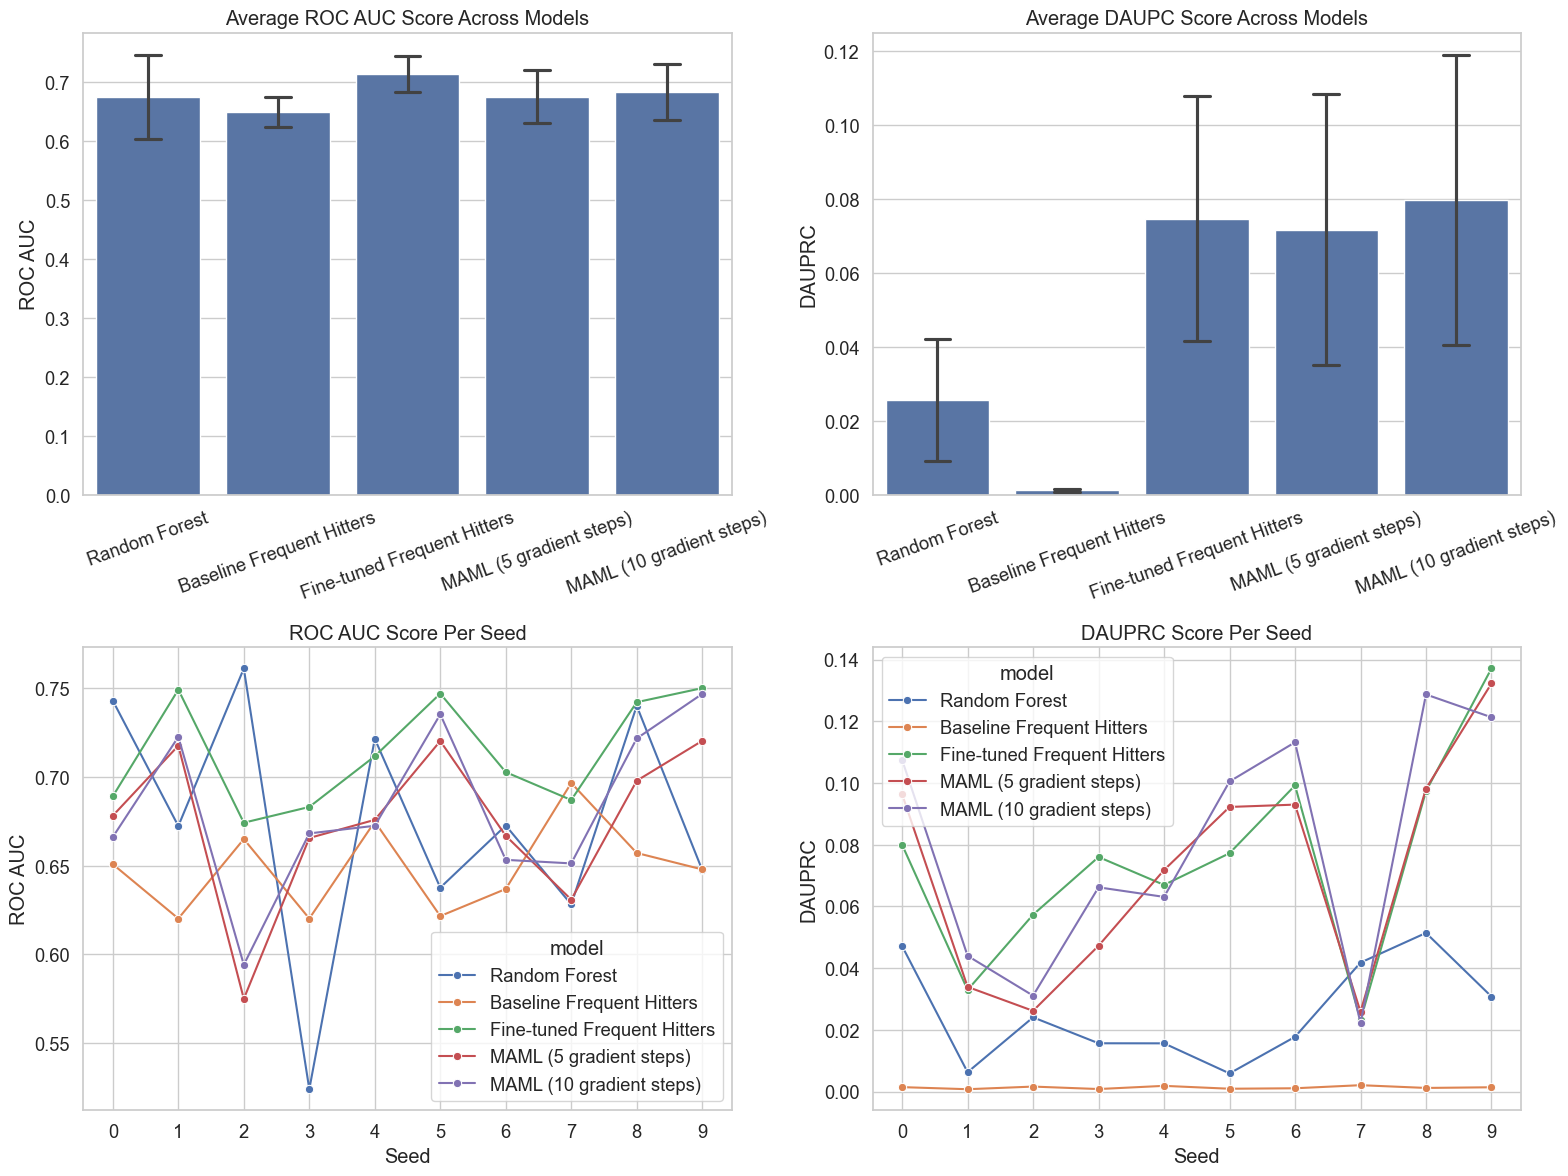

In [74]:
sns.set(style="whitegrid", font_scale=1.2)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC AUC Comparison (averaged)
sns.barplot(data=results_df, x="model", y="roc_auc", errorbar="sd", capsize=0.2, ax=axes[0, 0])
axes[0, 0].set_title("Average ROC AUC Score Across Models")
axes[0, 0].set_ylabel("ROC AUC")
axes[0, 0].set_xlabel("")
axes[0, 0].tick_params(axis="x", rotation=20)

# 2. DAUPRC Comparison (averaged)
sns.barplot(data=results_df, x="model", y="dauprc", errorbar="sd", capsize=0.2, ax=axes[0, 1])
axes[0, 1].set_title("Average DAUPC Score Across Models")
axes[0, 1].set_ylabel("DAUPRC")
axes[0, 1].set_xlabel("")
axes[0, 1].tick_params(axis="x", rotation=20)

# 3. ROC AUC Per Seed
sns.lineplot(data=results_df, x="seed", y="roc_auc", hue="model", marker="o", ax=axes[1, 0])
axes[1, 0].set_title("ROC AUC Score Per Seed")
axes[1, 0].set_ylabel("ROC AUC")
axes[1, 0].set_xlabel("Seed")
axes[1, 0].set_xticks(sorted(results_df["seed"].unique()))

# 4. DAUPRC Per Seed
sns.lineplot(data=results_df, x="seed", y="dauprc", hue="model", marker="o", ax=axes[1, 1])
axes[1, 1].set_title("DAUPRC Score Per Seed")
axes[1, 1].set_ylabel("DAUPRC")
axes[1, 1].set_xlabel("Seed")
axes[1, 1].set_xticks(sorted(results_df["seed"].unique()))

plt.tight_layout()
plt.show()